http://dbdesc.com/output_samples/htmlbrowse_northwind.html


# Case Study: Northwind Traders

## get sql db into merged pandas df
ie, aggregate all necessary data into one table/array

##### import packages and modules

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
import scipy.stats as stats
from math import sqrt
import math
import copy

import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import session, sessionmaker
from sqlalchemy import inspect # so we can perform high level investigations


import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
from matplotlib import style

pd.set_option('display.max_columns', None)

##### creating an engine object and a session to connect and work with the Northwind sql db

In [2]:
engine = create_engine("sqlite:///Northwind_small.sqlite", echo = True)
Session = sessionmaker(bind = engine)
session = Session
inspector = inspect(engine)

2019-04-28 20:37:03,642 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-04-28 20:37:03,646 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,647 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-04-28 20:37:03,648 INFO sqlalchemy.engine.base.Engine ()


##### looking at the table names

In [3]:
inspector.get_table_names()

2019-04-28 20:37:03,655 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-04-28 20:37:03,655 INFO sqlalchemy.engine.base.Engine ()


['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

##### For the first question, we only need Quantity and Discount though, I will aggregate all tables since we will need them later

##### map the db table features with their headings

In [4]:
from sqlalchemy import MetaData
from sqlalchemy.ext.automap import automap_base # creates a framework that clones the db structure so that it can generate a 
                                                  # a new model in which to map the db with its metadata, ie, column headings

In [5]:
metadata = MetaData()
metadata.reflect(engine)
Base = automap_base(metadata = metadata)
Base.prepare()



Category, Customer, CustomerCustomerDemo, CustomerDemographic, Employee, EmployeeTerritory, Order, OrderDetail,\
Product, Region, Shipper, Supplier, Territory = \
Base.classes.Category,\
Base.classes.Customer,\
Base.classes.CustomerCustomerDemo,\
Base.classes.CustomerDemographic, \
Base.classes.Employee, \
Base.classes.EmployeeTerritory,\
Base.classes.Order,\
Base.classes.OrderDetail, \
Base.classes.Product, \
Base.classes.Region,\
Base.classes.Shipper, \
Base.classes.Supplier, \
Base.classes.Territory

2019-04-28 20:37:03,679 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-04-28 20:37:03,681 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,684 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Category")
2019-04-28 20:37:03,685 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,687 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Category' AND type = 'table'
2019-04-28 20:37:03,688 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,689 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("Category")
2019-04-28 20:37:03,690 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,691 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Category' AND type = 'table'
2019-04-28 20:37:03,691 INFO sqlalchemy.engine.base.Engin

2019-04-28 20:37:03,769 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("EmployeeTerritory")
2019-04-28 20:37:03,770 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,771 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'EmployeeTerritory' AND type = 'table'
2019-04-28 20:37:03,772 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,773 INFO sqlalchemy.engine.base.Engine PRAGMA index_list("EmployeeTerritory")
2019-04-28 20:37:03,773 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,774 INFO sqlalchemy.engine.base.Engine PRAGMA index_list("EmployeeTerritory")
2019-04-28 20:37:03,774 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,775 INFO sqlalchemy.engine.base.Engine PRAGMA index_info("sqlite_autoindex_EmployeeTerritory_1")
2019-04-28 20:37:03,776 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,777 INFO sqlalchemy.engine.base.Engine SELECT sql 

2019-04-28 20:37:03,838 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Supplier")
2019-04-28 20:37:03,839 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,841 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Supplier' AND type = 'table'
2019-04-28 20:37:03,841 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,843 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("Supplier")
2019-04-28 20:37:03,843 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,844 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Supplier' AND type = 'table'
2019-04-28 20:37:03,845 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,846 INFO sqlalchemy.engine.base.Engine PRAGMA index_list("Supplier")
2019-04-28 20:37:03,847 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,848 INFO 

##### converting each table to a pandas dataframe

In [6]:
category_df= pd.read_sql_query("SELECT * FROM [category]", engine)
customer_df = pd.read_sql_query("SELECT * FROM [customer]", engine)
customerCustomerDemo_df = pd.read_sql_query("SELECT * FROM [customerCustomerDemo]", engine)
customerDemographic_df = pd.read_sql_query("SELECT * FROM [customerDemographic]", engine)
employee_df = pd.read_sql_query("SELECT * FROM [employee]", engine)
employeeTerritory_df = pd.read_sql_query("SELECT * FROM [employeeTerritory]", engine)
order_df = pd.read_sql_query("SELECT * FROM [order]", engine)
orderDetail_df = pd.read_sql_query("SELECT * FROM [orderDetail]", engine)
product_df = pd.read_sql_query("SELECT * FROM [product]", engine)
region_df = pd.read_sql_query("SELECT * FROM [region]", engine)
shipper_df = pd.read_sql_query("SELECT * FROM [shipper]", engine)
supplier_df = pd.read_sql_query("SELECT * FROM [supplier]", engine)
territory_df = pd.read_sql_query("SELECT * FROM [territory]", engine)

2019-04-28 20:37:03,892 INFO sqlalchemy.engine.base.Engine SELECT * FROM [category]
2019-04-28 20:37:03,893 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,898 INFO sqlalchemy.engine.base.Engine SELECT * FROM [customer]
2019-04-28 20:37:03,898 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,906 INFO sqlalchemy.engine.base.Engine SELECT * FROM [customerCustomerDemo]
2019-04-28 20:37:03,907 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,911 INFO sqlalchemy.engine.base.Engine SELECT * FROM [customerDemographic]
2019-04-28 20:37:03,911 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,916 INFO sqlalchemy.engine.base.Engine SELECT * FROM [employee]
2019-04-28 20:37:03,916 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,922 INFO sqlalchemy.engine.base.Engine SELECT * FROM [employeeTerritory]
2019-04-28 20:37:03,922 INFO sqlalchemy.engine.base.Engine ()
2019-04-28 20:37:03,926 INFO sqlalchemy.engine.base.Engine SELECT * FROM [order]
2019-04-28 

In [7]:
product_df.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [8]:
orderDetail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [9]:
order_df.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [10]:
all_df = list([
category_df,
customer_df ,
customerCustomerDemo_df, 
customerDemographic_df ,
employee_df ,
employeeTerritory_df, 
order_df ,
orderDetail_df, 
product_df ,
region_df ,
shipper_df ,
supplier_df ,
territory_df ])


In [11]:
for i in all_df:
    print(len(i))

8
91
0
0
9
49
830
2155
77
4
3
29
53


##### will join the following tables which will have useful info for further insights<br>
* category
* customer
* order 
* order detail
* product

##### must amend name for id column on Category table so I can complete a merge statement

In [12]:
category_df.rename(columns = {"Id":"CategoryId"}, inplace = True)

In [13]:
category_df.head()

,CategoryId,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"


In [14]:
cat_prod_df = pd.merge(category_df, product_df, on = "CategoryId" )
cat_prod_df.head()

,CategoryId,CategoryName,Description,Id,ProductName,SupplierId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",1,Chai,1,10 boxes x 20 bags,18.0,39,0,10,0
1,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",2,Chang,1,24 - 12 oz bottles,19.0,17,40,25,0
2,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",24,Guaraná Fantástica,10,12 - 355 ml cans,4.5,20,0,0,1
3,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",34,Sasquatch Ale,16,24 - 12 oz bottles,14.0,111,0,15,0
4,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",35,Steeleye Stout,16,24 - 12 oz bottles,18.0,20,0,15,0


In [15]:
len(cat_prod_df)

77

rename Id column on Product Table so I can merge OrderDetail Table

In [16]:
cat_prod_df.rename(columns = {"Id": "ProductId"}, inplace = True)
cat_prod_df.head(2)

,CategoryId,CategoryName,Description,ProductId,ProductName,SupplierId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",1,Chai,1,10 boxes x 20 bags,18.0,39,0,10,0
1,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",2,Chang,1,24 - 12 oz bottles,19.0,17,40,25,0


In [17]:
cat_prod_OrDtl_df = pd.merge(cat_prod_df, orderDetail_df, on = "ProductId")
cat_prod_OrDtl_df.head()

,CategoryId,CategoryName,Description,ProductId,ProductName,SupplierId,QuantityPerUnit,UnitPrice_x,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,OrderId,UnitPrice_y,Quantity,Discount
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",1,Chai,1,10 boxes x 20 bags,18.0,39,0,10,0,10285/1,10285,14.4,45,0.20
1,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",1,Chai,1,10 boxes x 20 bags,18.0,39,0,10,0,10294/1,10294,14.4,18,0.00
2,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",1,Chai,1,10 boxes x 20 bags,18.0,39,0,10,0,10317/1,10317,14.4,20,0.00
3,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",1,Chai,1,10 boxes x 20 bags,18.0,39,0,10,0,10348/1,10348,14.4,15,0.15
4,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",1,Chai,1,10 boxes x 20 bags,18.0,39,0,10,0,10354/1,10354,14.4,12,0.00


In [18]:
len(cat_prod_OrDtl_df)

2155

In [19]:
order_df.rename(columns = {"Id" : "OrderId"}, inplace = True)

In [20]:
cat_prod_OrDtl_orders_df = pd.merge(cat_prod_OrDtl_df, order_df, on = "OrderId" )
cat_prod_OrDtl_orders_df.head()

,CategoryId,CategoryName,Description,ProductId,ProductName,SupplierId,QuantityPerUnit,UnitPrice_x,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,OrderId,UnitPrice_y,Quantity,Discount,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",1,Chai,1,10 boxes x 20 bags,18.0,39,0,10,0,10285/1,10285,14.4,45,0.2,QUICK,1,2012-08-20,2012-09-17,2012-08-26,2,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany
1,6,Meat/Poultry,Prepared meats,53,Perth Pasties,24,48 pieces,32.8,0,0,0,1,10285/53,10285,26.2,36,0.2,QUICK,1,2012-08-20,2012-09-17,2012-08-26,2,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany
2,8,Seafood,Seaweed and fish,40,Boston Crab Meat,19,24 - 4 oz tins,18.4,123,0,30,0,10285/40,10285,14.7,40,0.2,QUICK,1,2012-08-20,2012-09-17,2012-08-26,2,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany
3,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",1,Chai,1,10 boxes x 20 bags,18.0,39,0,10,0,10294/1,10294,14.4,18,0.0,RATTC,4,2012-08-30,2012-09-27,2012-09-05,2,147.26,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,North America,87110,USA
4,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",43,Ipoh Coffee,20,16 - 500 g tins,46.0,17,10,25,0,10294/43,10294,36.8,15,0.0,RATTC,4,2012-08-30,2012-09-27,2012-09-05,2,147.26,Rattlesnake Canyon Grocery,2817 Milton Dr.,Albuquerque,North America,87110,USA


In [21]:
len(cat_prod_OrDtl_orders_df)

2155

In [22]:
customer_df.rename(columns ={"Id": "CustomerId"}, inplace = True)

In [23]:
df = pd.merge(cat_prod_OrDtl_orders_df, customer_df, on = "CustomerId")
df.head()

,CategoryId,CategoryName,Description,ProductId,ProductName,SupplierId,QuantityPerUnit,UnitPrice_x,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued,Id,OrderId,UnitPrice_y,Quantity,Discount,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",1,Chai,1,10 boxes x 20 bags,18.0,39,0,10,0,10285/1,10285,14.4,45,0.2,QUICK,1,2012-08-20,2012-09-17,2012-08-26,2,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None
1,6,Meat/Poultry,Prepared meats,53,Perth Pasties,24,48 pieces,32.8,0,0,0,1,10285/53,10285,26.2,36,0.2,QUICK,1,2012-08-20,2012-09-17,2012-08-26,2,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None
2,8,Seafood,Seaweed and fish,40,Boston Crab Meat,19,24 - 4 oz tins,18.4,123,0,30,0,10285/40,10285,14.7,40,0.2,QUICK,1,2012-08-20,2012-09-17,2012-08-26,2,76.83,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None
3,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",1,Chai,1,10 boxes x 20 bags,18.0,39,0,10,0,10691/1,10691,18.0,30,0.0,QUICK,2,2013-10-03,2013-11-14,2013-10-22,2,810.05,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None
4,1,Beverages,"Soft drinks, coffees, teas, beers, and ales",43,Ipoh Coffee,20,16 - 500 g tins,46.0,17,10,25,0,10691/43,10691,46.0,40,0.0,QUICK,2,2013-10-03,2013-11-14,2013-10-22,2,810.05,QUICK-Stop,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,QUICK-Stop,Horst Kloss,Accounting Manager,Taucherstraße 10,Cunewalde,Western Europe,01307,Germany,0372-035188,None


In [24]:
len(df)

2078

In [25]:

q1df = copy.deepcopy(df[["Quantity", "Discount"]])
q1df.head()

,Quantity,Discount
0,45,0.2
1,36,0.2
2,40,0.2
3,30,0.0
4,40,0.0


In [26]:
len(q1df)

2078

In [27]:
q1df.Discount.unique()

array([0.2 , 0.  , 0.25, 0.1 , 0.05, 0.15, 0.02, 0.03, 0.04, 0.06, 0.01])

In [28]:
q1df.Discount.value_counts()

0.00    1272
0.05     179
0.10     164
0.20     158
0.15     150
0.25     147
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

##### discounts of 1%, 2%, 3%, 4% and 6% are so infrequent that there are not enough observations to give meaningful insights 
will drop these obserations from the data set.

## EDA

In [29]:
q1df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2078 entries, 0 to 2077
Data columns (total 2 columns):
Quantity    2078 non-null int64
Discount    2078 non-null float64
dtypes: float64(1), int64(1)
memory usage: 48.7 KB


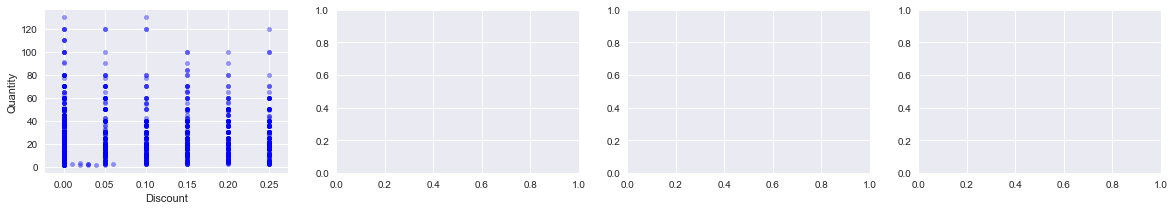

In [30]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (20,3))

for xcol, ax in zip(['Discount'], axes):
    q1df.plot(kind = 'scatter', x=xcol, y='Quantity', ax=ax, alpha=0.4, color='b')

In [31]:
q1df.head()

,Quantity,Discount
0,45,0.2
1,36,0.2
2,40,0.2
3,30,0.0
4,40,0.0


In [32]:
len(q1df)

2078

In [33]:
discountDf = q1df.groupby("Discount")
discountDf["Quantity"].mean()

Discount
0.00    21.900943
0.01     2.000000
0.02     2.000000
0.03     1.666667
0.04     1.000000
0.05    27.972067
0.06     2.000000
0.10    25.396341
0.15    28.773333
0.20    26.987342
0.25    27.829932
Name: Quantity, dtype: float64

##  Question 1

    *  Do discounts have a statistically significant effect on the number of products customers order?
    *  if so, at what level(s) of discount?

h0: mean sales with discount = mean sales w/o discount
h1: mean sales with discount > mean sales w/o discount

h0 = customer orders with discounts are equal to customer orders without discounts<br>
h1 = customer orders with discounts are greater than customer orders without discounts<br>
this is a one tailed test

whats the average...are orders with discounts greater than the average?

##### T-Test
##### separate observations by the discount levels

In [34]:
zeroP = q1df[q1df["Discount"]==0.0]
oneP = q1df[q1df["Discount"]==0.01]
twoP = q1df[q1df["Discount"]==0.02]
threeP = q1df[q1df["Discount"]==0.03]
fourP = q1df[q1df["Discount"]==0.04]
fiveP = q1df[q1df["Discount"]==0.05]
sixP = q1df[q1df["Discount"]==0.6]
tenP = q1df[q1df["Discount"]==0.10]
fifteenP = q1df[q1df["Discount"]==0.15]
twentyP = q1df[q1df["Discount"]==0.20]
twentyFiveP = q1df[q1df["Discount"]==0.25]

In [35]:
zeroP.head()

,Quantity,Discount
3,30,0.0
4,40,0.0
5,24,0.0
6,48,0.0
7,40,0.0


In [36]:
zeroP.Quantity.mean()

21.900943396226417